In [21]:
import NCrystal as NC
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "pdf"
from scipy.stats import qmc
import time

In [2]:
NC.__version__

'3.0.0'

## Scattering & absorption 

In [3]:
O2_scat = NC.createScatter('ncplugin-MagScat_O2_sg223_SolidOxygen-gamma.ncmat;dcutoff=0.5')
O2_abs  = NC.createAbsorption('ncplugin-MagScat_O2_sg223_SolidOxygen-gamma.ncmat;dcutoff=0.5')
E  = np.logspace(-7, 1,1000)
xs_scat = O2_scat.crossSectionNonOriented(E)
xs_abs  = O2_abs.crossSectionNonOriented(E)

## Magnetic scattering 

In [4]:
O2_down = NC.createScatter('ncplugin-MagScat_O2_sg223_SolidOxygen-gamma_down.ncmat;dcutoff=0.5;inelas=0;elas=0')
O2_up   = NC.createScatter('ncplugin-MagScat_O2_sg223_SolidOxygen-gamma_up.ncmat;dcutoff=0.5;inelas=0;elas=0')
E2 = np.logspace(-7,-1,1000)
xs_down = O2_down.crossSectionIsotropic(E2)
xs_up   = O2_up.crossSectionIsotropic(E2)

## Cross section visualization 

In [22]:
fig = make_subplots(rows = 1, cols = 1)
fig.add_trace(
    go.Scatter(
        x = E,
        y = xs_scat,
        mode = 'lines',
        name = 'Scattering',
    ),
    row = 1, col = 1
)
fig.add_trace(
    go.Scatter(
        x = E,
        y = xs_abs,
        mode = 'lines',
        name = 'Absorption',
    ),
    row = 1, col = 1
)
fig.add_trace(
    go.Scatter(
        x = E2,
        y = xs_down,
        mode = 'lines',
        name = 'Magnetic down-scat',
    ),
    row = 1, col = 1
)
fig.add_trace(
    go.Scatter(
        x = E2,
        y = xs_up,
        mode = 'lines',
        name = 'Magnetic up-scat',
    ),
    row = 1, col = 1
)
fig.update_xaxes(type = 'log', title = 'Incident neutron energy (eV)', 
                 exponentformat = 'power')
fig.update_yaxes(type = 'log', title = 'Cross section (barn)',
                 exponentformat = 'power')
fig.add_annotation(xref='paper',yref='paper',x=.9, y=.7, 
                   text=r'$\Large T=1\textrm{ K}$', showarrow=False)
fig.add_annotation(xref='paper',yref='paper',x=.9, y=.55, 
                   text=r'$\Large \textrm{Solid oxygen}$', showarrow=False)
fig.update_layout(margin = dict(l = 80, r = 20, t = 20, b = 60))
fig.show()

## Simple Monte-Carlo simulation 

In [6]:
O2_info = NC.createInfo('ncplugin-MagScat_O2_sg223_SolidOxygen-gamma.ncmat')

def sample_particle():
    E = 1 # eV
    frac = 0.25
    particle = {'energy':E,'fraction':frac}
    return particle

def AbsorptionXS(E,frac):
    return frac*O2_info.getNumberDensity()*O2_abs.crossSectionNonOriented(E)

def ScatteringXS(E,frac):
    return frac*O2_info.getNumberDensity()*O2_scat.crossSectionNonOriented(E)

def MagneticDownXS(E,frac):
    return frac*O2_info.getNumberDensity()*O2_down.crossSectionIsotropic(E)

def MagneticUpXS(E,frac):
    return frac*O2_info.getNumberDensity()*O2_up.crossSectionIsotropic(E)

def sample_scattering(p):
    return O2_scat.sampleScatterIsotropic(p['energy'])[0]

def sample_magnetic_down(p):
    return O2_down.sampleScatterIsotropic(p['energy'])[0]

def sample_magnetic_up(p):
    return O2_up.sampleScatterIsotropic(p['energy'])[0]

### Without magnetic effects 

In [7]:
start_time = time.time()
NPart = 5000
energies = []
weights = []
particles = [sample_particle() for i in range(NPart)]
sampler = qmc.LatinHypercube(d=1)

for p in particles:
    absorbed = False
    while not absorbed:
        #
        # Calculate XS for the current energies
        #
        Sigma_a = AbsorptionXS(p['energy'], p['fraction'])
        Sigma_s = ScatteringXS(p['energy'], p['fraction'])
        Sigma_t = Sigma_s + Sigma_a

        #
        # Increment tallies using collision estimator
        #
        energies.append(p['energy'])
        weights.append(1/Sigma_t)

        #
        # Handle reactions
        #
        r = sampler.random(n=1)
        if r < Sigma_a/Sigma_t:
            absorbed = True
        else:
            p['energy'] = sample_scattering(p)
print('Total computation time : {:.4g} s.'.format(time.time() - start_time))

Total computation time : 1110 s.


### With magnetic effects 

In [8]:
start_time = time.time()
NPart = 5000
energies_mag = []
weights_mag = []
particles = [sample_particle() for i in range(NPart)]
sampler = qmc.LatinHypercube(d=1)

for i, p in enumerate(particles):
    absorbed = False
    while not absorbed:
        #
        # Calculate XS for the current energies
        #
        Sigma_a = AbsorptionXS(p['energy'], p['fraction'])
        Sigma_s = ScatteringXS(p['energy'], p['fraction'])
        Sigma_r_d = MagneticDownXS(p['energy'], p['fraction'])
        Sigma_r_u = MagneticUpXS(p['energy'], p['fraction'])
        Sigma_t = Sigma_s + Sigma_a + Sigma_r_d + Sigma_r_u

        #
        # Increment tallies using collision estimator
        #
        energies_mag.append(p['energy'])
        weights_mag.append(1/Sigma_t)

        #
        # Handle reactions
        #
        r = sampler.random(n=1)
        if r < Sigma_a/Sigma_t:
            absorbed = True
        elif r < (Sigma_s+Sigma_a)/Sigma_t:
            p['energy'] = sample_scattering(p)
        elif r < (Sigma_r_u+Sigma_s+Sigma_a)/Sigma_t:
            p['energy'] = sample_magnetic_up(p)
        else:
            p['energy'] = sample_magnetic_down(p)
print('Total computation time : {:.4g} s.'.format(time.time() - start_time))

Total computation time : 64.02 s.


## Neutron distribution

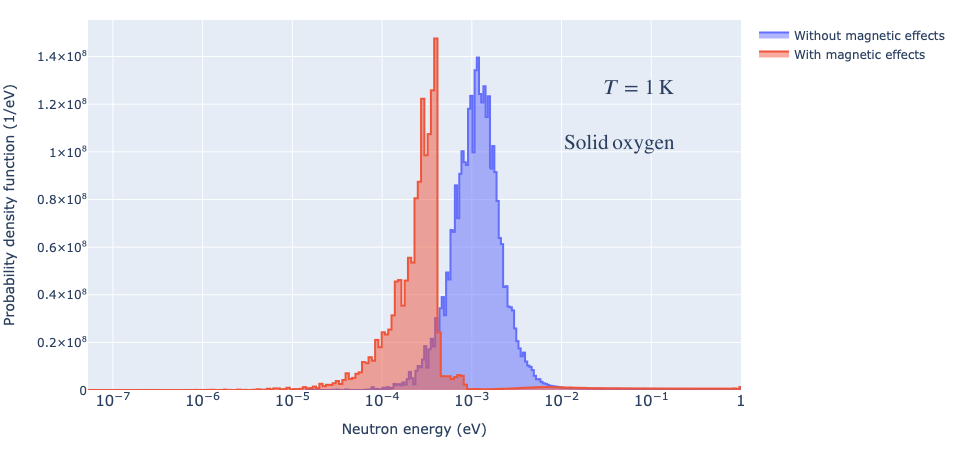

In [12]:
#
# Compute spectrum using collision estimator
#
vals, bins = np.histogram(np.log10(energies), weights=weights, bins=200)
vals_mag, bins_mag = np.histogram(np.log10(energies_mag), weights=weights_mag, bins=200)

fig = make_subplots(rows = 1, cols = 1)
fig.add_trace(
    go.Scatter(
        x = 10**bins[1:],
        y = vals,
        #mode = 'lines',
        line_shape='hvh',
        fill='tozeroy',
        name = 'Without magnetic effects',
    ),
    row = 1, col = 1
)
fig.add_trace(
    go.Scatter(
        x = 10**bins_mag[1:],
        y = vals_mag,
        #mode = 'lines',
        line_shape='hvh',
        fill='tozeroy',
        name = 'With magnetic effects',
    ),
    row = 1, col = 1
)
fig.update_xaxes(type = 'log', title = 'Neutron energy (eV)', 
                 exponentformat = 'power')
fig.update_yaxes(title = 'Probability density function (1/eV)',
                 exponentformat = 'power')
fig.add_annotation(xref='paper',yref='paper',x=.9, y=.85, 
                   text=r'$\Large T=1\textrm{ K}$', showarrow=False)
fig.add_annotation(xref='paper',yref='paper',x=.9, y=.7, 
                   text=r'$\Large \textrm{Solid oxygen}$', showarrow=False)
fig.update_layout(margin = dict(l = 80, r = 20, t = 20, b = 60))
fig.show()